# Snake

In [1]:
import sys, os
import keras.api._v2.keras as K
import tensorflow as tf
import numpy as np
from  tqdm import trange
import matplotlib.pyplot as plt
from multiprocessing import Pool
import multiprocessing.dummy as dummy
from multiprocessing import cpu_count
from itertools import islice
from simulate_chunck_boards import process_boards
from itertools import repeat

In [2]:
def chunk(it, size):
    it = iter(it)
    return iter(lambda: tuple(islice(it, size)), ())

## Environment definition

In [3]:
BOARD_SIZE = 5

In [4]:
# agent = K.models.Sequential()
# agent.add(K.layers.Flatten(input_shape=(BOARD_SIZE,BOARD_SIZE,4)))
# agent.add(K.layers.Dense(256, activation='selu'))
# agent.add(K.layers.Dense(256, activation='selu'))
# agent.add(K.layers.Dense(4, activation='softmax'))
# [up, right, bottom, left]

input = K.layers.Input(shape=(BOARD_SIZE, BOARD_SIZE, 3))
x = K.layers.Conv2D(32, (3,3), padding="SAME", activation="linear", use_bias=False)(input)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

x = K.layers.Conv2D(32, (3,3), padding="SAME", activation="linear", use_bias=False)(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

x = K.layers.MaxPool2D(2)(x)

x = K.layers.Conv2D(32, (2,2), padding="SAME", activation="linear", use_bias=False)(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

x = K.layers.Conv2D(8, (2,2), padding="SAME", activation="linear", use_bias=False)(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)
x = K.layers.GlobalAvgPool2D()(x)


Metal device set to: Apple M1 Max


2022-12-23 15:31:13.788019: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-23 15:31:13.788176: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
encoder = K.Model(inputs=input, outputs=x)

In [6]:
dec = K.layers.Reshape((1,1,-1))(x)
dec = K.layers.Conv2DTranspose(32, 2, activation=tf.nn.leaky_relu)(dec)
dec = K.layers.Conv2DTranspose(32, 2, activation=tf.nn.leaky_relu)(dec)
dec = K.layers.Conv2DTranspose(32, 2, activation=tf.nn.leaky_relu)(dec)
dec = K.layers.Conv2DTranspose(3, 2, activation=tf.nn.softmax)(dec)
decoder = K.Model(inputs=x, outputs=dec)

In [7]:
ae = K.models.Sequential([
    encoder,
    decoder
])

In [8]:
policy = K.layers.Dense(64, activation=tf.nn.leaky_relu)(x)
policy = K.layers.Dense(64, activation=tf.nn.leaky_relu)(policy)
policy = K.layers.Dense(4, activation=tf.nn.softmax)(policy)
agent = K.models.Model(inputs=input, outputs=policy)

In [9]:
# value = K.models.Sequential()
# value.add(K.layers.Flatten(input_shape=(BOARD_SIZE,BOARD_SIZE,4)))
# value.add(K.layers.Dense(256, activation='selu'))
# value.add(K.layers.Dense(256, activation='selu'))
# value.add(K.layers.Dense(1, activation='linear'))
vf = K.layers.Dense(64, activation=tf.nn.leaky_relu)(x)
vf = K.layers.Dense(64, activation=tf.nn.leaky_relu)(vf)
vf = K.layers.Dense(1, activation="linear")(vf)
value = K.models.Model(inputs=input, outputs=vf)

In [10]:
#agent.load_weights(f"models/{BOARD_SIZE}x{BOARD_SIZE}_bigger/agent")
#value.load_weights(f"models/{BOARD_SIZE}x{BOARD_SIZE}_bigger/value")

In [11]:
class BaseEnvironment:
    def __init__(self, n_boards, board_size):
        self.UP = 0
        self.RIGHT = 1
        self.DOWN = 2
        self.LEFT = 3

        self.WIN_REWARD = 10000
        self.FRUIT_REWARD = 10
        self.STEP_REWARD = 0
        self.ATE_HIMSELF_REWARD = 10 # scalar to multiply to -len(eaten body)

        self.HEAD = 3
        self.BODY = 2
        self.FRUIT = 1
        self.EMPTY = 0

        self.board_size = board_size
        self.n_boards = n_boards
        self.boards = np.zeros((self.n_boards, self.board_size, self.board_size))
        for board in self.boards:
            i = np.random.randint(0,self.board_size); j = np.random.randint(0,self.board_size)
            board[i,j] = self.HEAD
            while board[i,j] != 0:
                i = np.random.randint(0,self.board_size); j = np.random.randint(0,self.board_size)
            board[i,j] = self.FRUIT
        self.bodies = [[] for _ in range(self.n_boards)]

In [12]:
class SequentialEnvironment(BaseEnvironment):
    def __init__(self, n_boards, board_size):
        super().__init__(n_boards, board_size)

    def move(self, actions):
        rewards = []
        # [up, right, bottom, left]
        for board_count, (board, action, body) in enumerate(zip(self.boards, actions, self.bodies)):
            if tf.reduce_sum(board) - 5 == (self.board_size**2 - 3) * self.BODY:
                print("won")
                rewards.append(self.WIN_REWARD)
                board = np.zeros(self.board_size, self.board_size)
                i = np.random.randint(0,self.board_size); j = np.random.randint(0,self.board_size)
                board[i,j] = self.HEAD
                while board[i,j] != 0:
                    i = np.random.randint(0,self.board_size); j = np.random.randint(0,self.board_size)
                board[i,j] = self.FRUIT
                body = []

            dx = 0; dy = 0
            if action in [self.UP,self.DOWN]:
                dx = 1 if action == self.UP else -1
            if action in [self.RIGHT,self.LEFT]:
                dy = 1 if action == self.RIGHT else -1
            head = tf.cast(tf.where(board == self.HEAD)[0], dtype=tf.int32)
            fruit = tf.cast(tf.where(board == self.FRUIT)[0], dtype=tf.int32)

            body.insert(0, head)
            board[tuple(head.numpy())] = self.BODY

            # eat fruit
            if tf.reduce_all(tf.equal(head + [dx, dy], fruit)):
                board[tuple(fruit.numpy())] = self.EMPTY
                i = np.random.randint(0,self.board_size); j = np.random.randint(0,self.board_size)
                while board[i,j] != 0 and tf.reduce_all(tf.equal(head + [dx, dy], [i,j])):
                    i = np.random.randint(0,self.board_size); j = np.random.randint(0,self.board_size)
                board[i,j] = self.FRUIT
                rewards.append(self.FRUIT_REWARD)
            # he eats himself
            elif tf.reduce_any(tf.reduce_all(tf.equal(body, tf.repeat(tf.expand_dims(head + [dx, dy], axis=0), len(body), axis=0)), axis=-1)):
                since = tf.where(tf.reduce_all(tf.equal(body, tf.repeat(tf.expand_dims(head + [dx, dy], axis=0), len(body), axis=0)), axis=-1))[0,0]
                pieces_eaten = len(body) - since
                for pos in body[since:]:
                    board[tuple(pos)] = self.EMPTY
                del body[since:]
                position = body.pop()
                board[tuple(position.numpy())] = self.EMPTY
                rewards.append(-pieces_eaten * self.ATE_HIMSELF_REWARD)
            # doesn't eat fruit
            else:
                position = body.pop()
                board[tuple(position.numpy())] = self.EMPTY
                rewards.append(self.STEP_REWARD)

            board[tuple(head + [dx, dy])] = self.HEAD

            if tf.size(tf.where(board == self.FRUIT)) == 0:
                # probably better to check the indexes where the board is free and pick one at random
                i = np.random.randint(0,self.board_size); j = np.random.randint(0,self.board_size)
                while board[i,j] != 0:
                    i = np.random.randint(0,self.board_size); j = np.random.randint(0,self.board_size)
                board[i,j] = self.FRUIT


        return tf.reshape(tf.convert_to_tensor(rewards, dtype=tf.float32), (-1,1))

In [13]:
# for "small batch" < 2000
class ProcessEnvironment(BaseEnvironment):
    def __init__(self, n_boards, board_size):
        super().__init__(n_boards, board_size)

    def move(self, actions):
        rewards = [0] * self.n_boards
        def process_board(elems):
            board_count, (board, action, body) = elems
            if tf.reduce_sum(board) - 5 == (self.board_size**2 - 3) * self.BODY:
                print("won")
                rewards[board_count] = self.WIN_REWARD
                board = np.zeros(self.board_size, self.board_size)
                i = np.random.randint(0,self.board_size); j = np.random.randint(0,self.board_size)
                board[i,j] = self.HEAD
                while board[i,j] != 0:
                    i = np.random.randint(0,self.board_size); j = np.random.randint(0,self.board_size)
                board[i,j] = self.FRUIT
                del body[:]

            dx = 0; dy = 0
            if action in [self.UP,self.DOWN]:
                dx = 1 if action == self.UP else -1
            if action in [self.RIGHT,self.LEFT]:
                dy = 1 if action == self.RIGHT else -1
            head = tf.cast(tf.where(board == self.HEAD)[0], dtype=tf.int32)
            fruit = tf.cast(tf.where(board == self.FRUIT)[0], dtype=tf.int32)

            body.insert(0, head)
            board[tuple(head.numpy())] = self.BODY

            # eat fruit
            if tf.reduce_all(tf.equal(head + [dx, dy], fruit)):
                board[tuple(fruit.numpy())] = self.EMPTY
                i = np.random.randint(0,self.board_size); j = np.random.randint(0,self.board_size)
                while board[i,j] != 0 and tf.reduce_all(tf.equal(head + [dx, dy], [i,j])):
                    i = np.random.randint(0,self.board_size); j = np.random.randint(0,self.board_size)
                board[i,j] = self.FRUIT
                rewards[board_count] = self.FRUIT_REWARD
            # he eats himself
            elif tf.reduce_any(tf.reduce_all(tf.equal(body, tf.repeat(tf.expand_dims(head + [dx, dy], axis=0), len(body), axis=0)), axis=-1)):
                since = tf.where(tf.reduce_all(tf.equal(body, tf.repeat(tf.expand_dims(head + [dx, dy], axis=0), len(body), axis=0)), axis=-1))[0,0]
                pieces_eaten = len(body) - since
                for pos in body[since:]:
                    board[tuple(pos)] = self.EMPTY
                del body[since:]
                position = body.pop()
                board[tuple(position.numpy())] = self.EMPTY
                rewards[board_count] = -pieces_eaten * self.ATE_HIMSELF_REWARD
            # doesn't eat fruit
            else:
                position = body.pop()
                board[tuple(position.numpy())] = self.EMPTY
                rewards[board_count] = self.STEP_REWARD

            board[tuple(head + [dx, dy])] = self.HEAD

            if tf.size(tf.where(board == self.FRUIT)) == 0:
                # probably better to check the indexes where the board is free and pick one at random
                i = np.random.randint(0,self.board_size); j = np.random.randint(0,self.board_size)
                while board[i,j] != 0:
                    i = np.random.randint(0,self.board_size); j = np.random.randint(0,self.board_size)
                board[i,j] = self.FRUIT

        with dummy.Pool(cpu_count()) as p:
            _ = p.map(process_board, enumerate(zip(self.boards, actions, self.bodies)))
        return tf.reshape(tf.convert_to_tensor(rewards, dtype=tf.float32), (-1,1))

In [14]:
# for "small batch" < 2000
class ChunkProcessEnvironment(BaseEnvironment):
    def __init__(self, n_boards, board_size, chunk_size=25):
        super().__init__(n_boards, board_size)
        self.chunk_size = chunk_size
        self.pool = dummy.Pool(cpu_count())
    def close_pool(self):
        self.pool.close()
    def reset_pool(self):
        self.close_pool()
        self.pool = Pool(cpu_count())
    def __del__(self):
        self.close_pool()

    def move(self, actions):
        rewards = [0] * self.n_boards
        def process_board(elems):
            for board_count, board, action, body in elems:
                if tf.reduce_sum(board) - 5 == (self.board_size**2 - 3) * self.BODY:
                    print("won")
                    rewards[board_count] = self.WIN_REWARD
                    board = np.zeros(self.board_size, self.board_size)
                    i = np.random.randint(0,self.board_size); j = np.random.randint(0,self.board_size)
                    board[i,j] = self.HEAD
                    while board[i,j] != 0:
                        i = np.random.randint(0,self.board_size); j = np.random.randint(0,self.board_size)
                    board[i,j] = self.FRUIT
                    del body[:]

                dx = 0; dy = 0
                if action in [self.UP,self.DOWN]:
                    dx = 1 if action == self.UP else -1
                if action in [self.RIGHT,self.LEFT]:
                    dy = 1 if action == self.RIGHT else -1
                head = tf.cast(tf.where(board == self.HEAD)[0], dtype=tf.int32)
                fruit = tf.cast(tf.where(board == self.FRUIT)[0], dtype=tf.int32)

                body.insert(0, head)
                board[tuple(head.numpy())] = self.BODY

                # eat fruit
                if tf.reduce_all(tf.equal(head + [dx, dy], fruit)):
                    board[tuple(fruit.numpy())] = self.EMPTY
                    i = np.random.randint(0,self.board_size); j = np.random.randint(0,self.board_size)
                    while board[i,j] != 0 and tf.reduce_all(tf.equal(head + [dx, dy], [i,j])):
                        i = np.random.randint(0,self.board_size); j = np.random.randint(0,self.board_size)
                    board[i,j] = self.FRUIT
                    rewards[board_count] = self.FRUIT_REWARD
                # he eats himself
                elif tf.reduce_any(tf.reduce_all(tf.equal(body, tf.repeat(tf.expand_dims(head + [dx, dy], axis=0), len(body), axis=0)), axis=-1)):
                    since = tf.where(tf.reduce_all(tf.equal(body, tf.repeat(tf.expand_dims(head + [dx, dy], axis=0), len(body), axis=0)), axis=-1))[0,0]
                    pieces_eaten = len(body) - since
                    for pos in body[since:]:
                        board[tuple(pos)] = self.EMPTY
                    del body[since:]
                    position = body.pop()
                    board[tuple(position.numpy())] = self.EMPTY
                    rewards[board_count] = -pieces_eaten * self.ATE_HIMSELF_REWARD
                # doesn't eat fruit
                else:
                    position = body.pop()
                    board[tuple(position.numpy())] = self.EMPTY
                    rewards[board_count] = self.STEP_REWARD

                board[tuple(head + [dx, dy])] = self.HEAD

                if tf.size(tf.where(board == self.FRUIT)) == 0:
                    # probably better to check the indexes where the board is free and pick one at random
                    i = np.random.randint(0,self.board_size); j = np.random.randint(0,self.board_size)
                    while board[i,j] != 0:
                        i = np.random.randint(0,self.board_size); j = np.random.randint(0,self.board_size)
                    board[i,j] = self.FRUIT


        _ = self.pool.map(process_board, chunk(zip(np.arange(0, self.n_boards), self.boards, actions, self.bodies),self.chunk_size))
        return tf.reshape(tf.convert_to_tensor(rewards, dtype=tf.float32), (-1,1))
    def to_state(self):
        return K.utils.to_categorical(self.boards)[...,1:]

In [39]:
# for "big batch" > 2000
class ThreadEnvironment(BaseEnvironment):
    def __init__(self, n_boards, board_size, chunk_size = 25, cpu_threads_multiplier=1):
        super().__init__(n_boards, board_size)
        self.chunk_size = chunk_size
        # open 2 fds
        null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]

        save = os.dup(1), os.dup(2)
        os.dup2(null_fds[0], 1)
        os.dup2(null_fds[1], 2)
        self.pool = Pool(cpu_count()*cpu_threads_multiplier)
        os.dup2(save[0], 1)
        os.dup2(save[1], 2)
        os.close(null_fds[0])
        os.close(null_fds[1])
    def close_pool(self):
        self.pool.close()
    def reset_pool(self):
        self.close_pool()
        self.pool = Pool(cpu_count())
    def __del__(self):
        self.close_pool()
    def move(self, actions):
        # open 2 fds
        null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # save the current file descriptors to a tuple
        save = os.dup(1), os.dup(2)
        # put /dev/null fds on 1 and 2
        os.dup2(null_fds[0], 1)
        os.dup2(null_fds[1], 2)
        rewards = self.pool.map(process_boards,
                        chunk(zip(
                            repeat({
                                "UP": self.UP,
                                "DOWN": self.DOWN,
                                "LEFT": self.LEFT,
                                "RIGHT": self.RIGHT,
                                "HEAD": self.HEAD,
                                "BODY": self.BODY,
                                "FRUIT": self.FRUIT,
                                "EMPTY": self.EMPTY,
                                "WIN_REWARD": self.WIN_REWARD,
                                "FRUIT_REWARD": self.FRUIT_REWARD,
                                "STEP_REWARD": self.STEP_REWARD,
                                "ATE_HIMSELF_REWARD": self.ATE_HIMSELF_REWARD,
                                "board_size": self.board_size

                            }, times=len(self.boards)),
                            self.boards,
                            actions,
                            self.bodies
                        ), self.chunk_size))

        # restore file descriptors so I can print the results
        os.dup2(save[0], 1)
        os.dup2(save[1], 2)

        # close the temporary fds
        os.close(null_fds[0])
        os.close(null_fds[1])


        return tf.reshape(tf.convert_to_tensor(rewards, dtype=tf.float32), (-1,1))
    def to_state(self):
        return K.utils.to_categorical(self.boards)[...,1:]

In [40]:
# %%time
# %lprun -f simulate simulate(5)

## Training

In [41]:
# Given a state and a distributions of actions, removes those that are not "available" and re-normalize the distribution,
# as done in the paper of AlphaGo/AlphaZero
def re_normalize_possible_actions(state, probs, mask_with=np.finfo(np.float32).min):
    state = tf.argmax(state, axis=-1)
    indexes = tf.where(state == 2)
    mask = np.ones_like(probs)

    # [up, right, bottom, left]
    left_border = tf.where(indexes[:,2] == 0)
    left_border = tf.concat((left_border, tf.ones_like(left_border)*3), axis=-1)
    mask = tf.tensor_scatter_nd_update(mask, left_border, mask_with * tf.ones(left_border.shape[0]))

    right_border = tf.where(indexes[:,2] == BOARD_SIZE-1)
    right_border = tf.concat((right_border, tf.ones_like(right_border)*1), axis=-1)
    mask = tf.tensor_scatter_nd_update(mask, right_border, mask_with * tf.ones(right_border.shape[0]))


    top_border = tf.where(indexes[:,1] == BOARD_SIZE-1)
    top_border = tf.concat((top_border, tf.ones_like(top_border)*0), axis=-1)
    mask = tf.tensor_scatter_nd_update(mask, top_border, mask_with * tf.ones(top_border.shape[0]))

    bottom_border = tf.where(indexes[:,1] == 0)
    bottom_border = tf.concat((bottom_border, tf.ones_like(bottom_border)*2), axis=-1)
    mask = tf.tensor_scatter_nd_update(mask, bottom_border, mask_with * tf.ones(bottom_border.shape[0]))
    return tf.nn.softmax(probs * tf.stop_gradient(mask))

In [46]:
env_ = ThreadEnvironment(1000, BOARD_SIZE, chunk_size=10, cpu_threads_multiplier=2)
GAMMA = .99

In [47]:
agent.load_weights(f"models/{BOARD_SIZE}x{BOARD_SIZE}_bigger/agent")
value.load_weights(f"models/{BOARD_SIZE}x{BOARD_SIZE}_bigger/value")
ae.load_weights(f"models/{BOARD_SIZE}x{BOARD_SIZE}_bigger/ae")

In [48]:
optimizer_value = K.optimizers.Adam(1e-4)
optimizer_agent = K.optimizers.Adam(1e-4)
optimizer_autoencoder= K.optimizers.Adam(1e-5)

In [49]:
avg_rewards = []
ae_losses = []
for iterations in trange(50):
    state = env_.to_state()
    #try:
    if iterations % 25 == 0:
        agent.save_weights(f"models/{BOARD_SIZE}x{BOARD_SIZE}_bigger/agent")
        value.save_weights(f"models/{BOARD_SIZE}x{BOARD_SIZE}_bigger/value")
        ae.save_weights(f"models/{BOARD_SIZE}x{BOARD_SIZE}_bigger/ae")

    with tf.GradientTape(persistent=True) as tape:
        # calculate distributions of actions
        original_probs = agent(
            state
        )
        # remove actions that are not available
        probs = re_normalize_possible_actions(
            state,
            original_probs
        )
        #sample actions
        actions =  tf.random.categorical(tf.math.log(tf.stop_gradient(probs)), 1, dtype=tf.int32)

        # MDP update
        rewards = env_.move(actions)
        new_state = env_.to_state()

        # TD error
        value_state = value(state)
        td_error = tf.stop_gradient((rewards + GAMMA * value(new_state, training=False)) - value_state) * -1 # to do gradient ascend

        # calculate the loss for both value and agent
        actions_indexes = tf.concat((tf.range(actions.shape[0])[...,None] , actions), axis=-1)

        # maybe introduce eligibility trace to simulate n-step td, to have longer dependencies
        loss_agent = tf.stop_gradient(td_error) * tf.math.log(tf.gather_nd(probs, actions_indexes))
        loss_value = tf.stop_gradient(td_error) * value_state
        rec = ae(state)
        loss = tf.reduce_sum(K.losses.CategoricalCrossentropy()(state, rec))

    ae_losses.append(loss)

    grad = tape.gradient(loss, ae.trainable_weights)
    optimizer_autoencoder.apply_gradients(zip(grad, ae.trainable_weights))

    # calculate gradient
    gradient_agent = tape.gradient(loss_agent, agent.trainable_weights)
    gradient_value = tape.gradient(loss_value, value.trainable_weights)
    avg_rewards.append(tf.reduce_mean(rewards))

    # update neural nets weights
    optimizer_agent.apply_gradients(zip(gradient_agent, agent.trainable_weights))
    optimizer_value.apply_gradients(zip(gradient_value, value.trainable_weights))

    # just to be sure that long trainings do not end for some strange reason...
    # except Exception as e:
    #     print(e)
    #     print("Resetting env")
    #     env_ = ProcessEnvironment(200, BOARD_SIZE)

 34%|███▍      | 17/50 [01:40<03:16,  5.94s/it]


KeyboardInterrupt: 

 ### Random policy reward

In [416]:
random_env_ = ProcessEnvironment(100, BOARD_SIZE)
random_rewards = []

for _ in trange(1000):
    state = K.utils.to_categorical(random_env_.boards)
    probs = re_normalize_possible_actions(
        state,
        tf.repeat([[.25]*4],100, axis=0)
    )
    #sample actions
    actions =  tf.random.categorical(tf.math.log(probs), 1, dtype=tf.int32)

    # MDP update
    rewards = random_env_.move(actions)
    random_rewards.append(tf.reduce_mean(rewards))

100%|██████████| 1000/1000 [05:31<00:00,  3.02it/s]


## Training evaluation

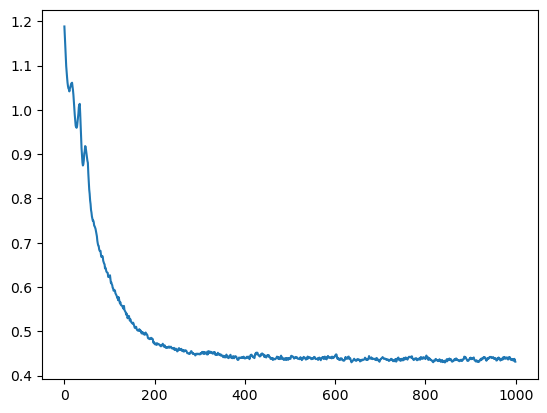

In [420]:
plt.plot(ae_losses)

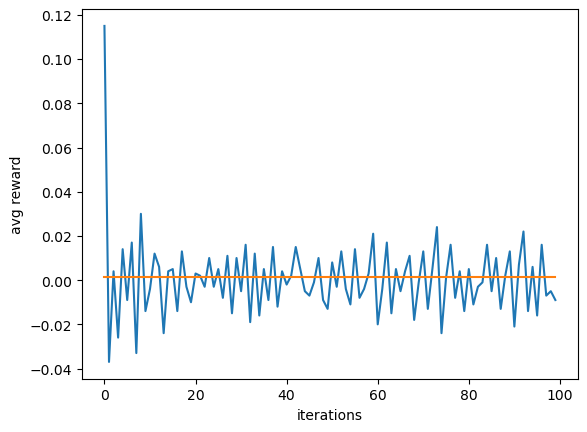

In [419]:
%matplotlib inline
plt.plot(np.array(avg_rewards).reshape((-1, 10)).mean(axis=-1))
n = np.array(avg_rewards).reshape((-1, 10)).mean(axis=-1).shape[0]
plt.plot(np.arange(0, n), np.repeat(np.mean(random_rewards), n))
_ = plt.xlabel("iterations")
_ = plt.ylabel("avg reward")

## Test (graphical simulation)

In [175]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [176]:
test_env = ProcessEnvironment(10,BOARD_SIZE)

In [177]:
def animate(_):
    state = K.utils.to_categorical(test_env.boards)
    original_probs = agent(
        state
    )
    probs = re_normalize_possible_actions(
        state,
        original_probs
    )
    log_probs = tf.math.log(tf.stop_gradient(probs))
    actions =  tf.random.categorical(log_probs, 1, dtype=tf.int32)
    test_env.move(actions)
    image.set_data(test_env.boards[0])
    return image

In [178]:
fig = plt.figure()
image = plt.imshow(test_env.boards[0], origin="lower")
anim = FuncAnimation(fig, animate, frames=3,
                     interval=10)

<IPython.core.display.Javascript object>